In [21]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_csv("patient_data.csv")

numeric_cols = ['Age', 'CholesterolLevel', 'BloodPressure']
dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].mean())


Q1 = dataset['CholesterolLevel'].quantile(0.25)
Q3 = dataset['CholesterolLevel'].quantile(0.75)
IQR = (Q3 - Q1)
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR

dataset_no_outliers = dataset[(dataset['CholesterolLevel'] >= lower) & (dataset['CholesterolLevel'] <= upper)]


dataset_encoded = pd.get_dummies(dataset_no_outliers[['Gender', 'Region', 'RiskCategory']], drop_first=True)


dataset_combined = pd.concat([dataset_no_outliers[numeric_cols], dataset_encoded], axis = 1)


selector = VarianceThreshold(threshold=0.0)
selector.fit(dataset_combined)
selected_features = dataset_combined.columns[selector.get_support()]
dataset_reduced = dataset_combined[selected_features]


print("dataset Shape after removing outliers:", dataset_no_outliers.shape)
print("dataset Shape after feature reduction:", dataset_reduced.shape)
print("Selected features:\n", selected_features.tolist())

dataset Shape after removing outliers: (98, 7)
dataset Shape after feature reduction: (98, 9)
Selected features:
 ['Age', 'CholesterolLevel', 'BloodPressure', 'Gender_Male', 'Region_North', 'Region_South', 'Region_West', 'RiskCategory_Low', 'RiskCategory_Medium']


Q2: Data Visualization 

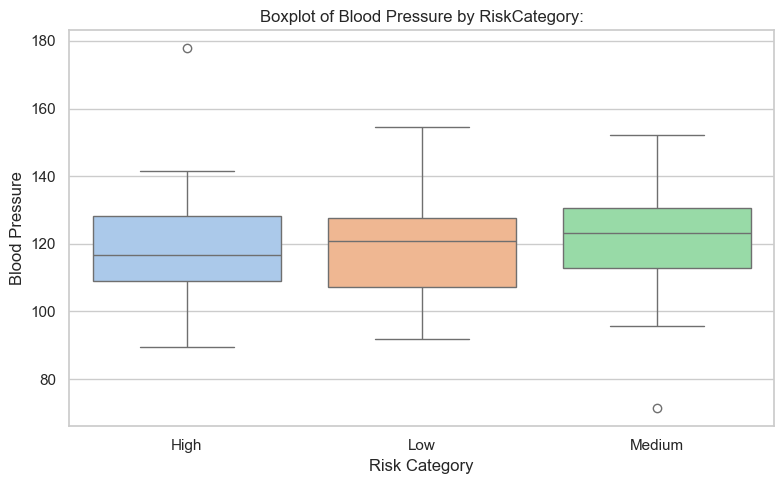

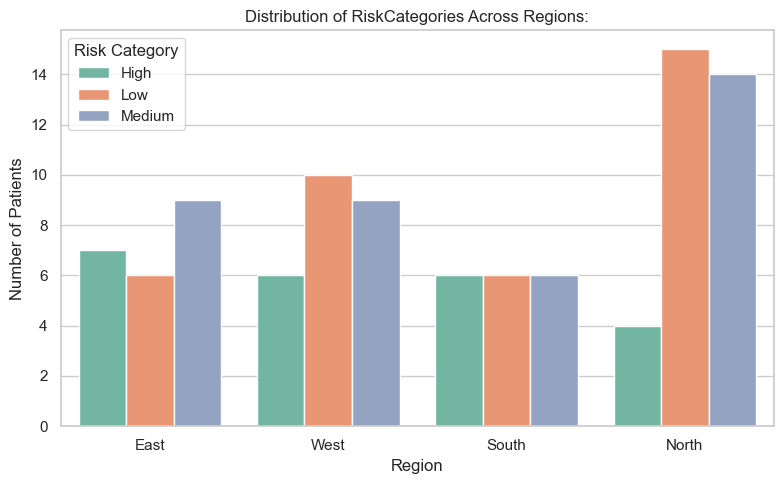

In [16]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.boxplot(
    x="RiskCategory",
    y="BloodPressure",
    hue="RiskCategory",          
    data=dataset_no_outliers,
    palette="pastel",
    legend=False              
           )
plt.title("Boxplot of Blood Pressure by RiskCategory:")
plt.xlabel("Risk Category")
plt.ylabel("Blood Pressure")
plt.tight_layout()
plt.show()

# 2. Countplot of RiskCategory grouped by Region (no changes needed)
plt.figure(figsize=(8, 5))
sns.countplot(
    data=dataset_no_outliers,
    x="Region",
    hue="RiskCategory",
    palette="Set2"
             )
plt.title("Distribution of RiskCategories Across Regions:")
plt.xlabel("Region")
plt.ylabel("Number of Patients")
plt.legend(title="Risk Category")
plt.tight_layout()
plt.show()


Q3: Statistical Hypothesis Testing

In [18]:
from scipy.stats import ttest_1samp, chi2_contingency
import random
dataset[['CholesterolLevel']] = dataset[['CholesterolLevel']].fillna(dataset['CholesterolLevel'].mean())

sample = dataset['CholesterolLevel'].sample(20, random_state=1)
t_stat, p = ttest_1samp(sample, 200)
print("T-test p-value:", round(p, 4))
print("Conclusion:", "Reject null hypo" if p < 0.05 else "Fail to Reject null hypo")

table = pd.crosstab(dataset['Region'], dataset['RiskCategory'])
chi2, p2, dof, _ = chi2_contingency(table)
print("\nChi-square p-value:", round(p2, 4))
print("\nConclusion:", "Reject null hypo" if p2 < 0.05 else "Fail to Reject null hypo")

T-test p-value: 0.2565
Conclusion: Fail to Reject null hypo

Chi-square p-value: 0.6043

Conclusion: Fail to Reject null hypo


Q4: Modeling a Health System with ODE

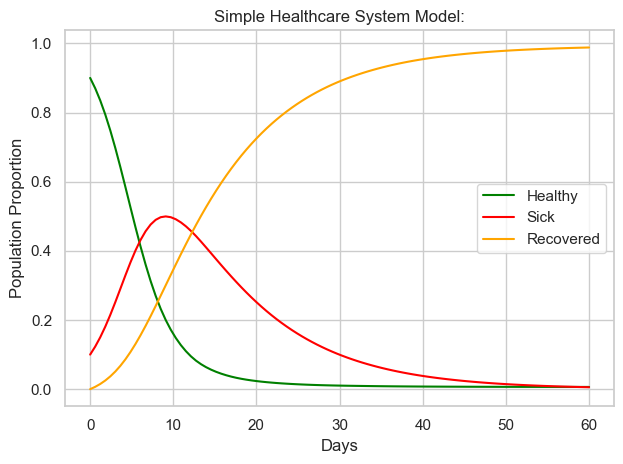

In [19]:
from scipy.integrate import solve_ivp

def model(t, y):
    H, S, R = y
    beta = 0.5 
    gamma = 0.1 
    dH = -beta * H*S
    dS = beta*H*S - gamma*S
    dR = gamma*S
    return [dH, dS, dR]

H0 = 0.9 
S0 = 0.1  
R0 = 0.0  
start = 0
end = 60

t = np.linspace(start, end, 100)

result = solve_ivp(model, [start, end], [H0, S0, R0], t_eval=t)

plt.plot(result.t, result.y[0], label="Healthy", color="green")
plt.plot(result.t, result.y[1], label="Sick", color="red")
plt.plot(result.t, result.y[2], label="Recovered", color="orange")
plt.title("Simple Healthcare System Model:")
plt.xlabel("Days")
plt.ylabel("Population Proportion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()